# Adadelta --- 从0开始


我们在[Adagrad](adagrad-scratch.md)里提到，由于学习率分母上的变量$\mathbf{s}$一直在累加按元素平方的梯度，每个元素的学习率在迭代过程中一直在降低或不变。所以在有些问题下，当学习率在迭代早期降得较快时且当前解依然不理想时，Adagrad在迭代后期可能较难找到一个有用的解。我们在[RMSProp](rmsprop-scratch.md)介绍了应对这一问题的一种方法：对梯度按元素平方使用指数加权移动平均而不是累加。

事实上，Adadelta也是一种应对这个问题的方法。有意思的是，它没有学习率参数。


## Adadelta算法

Adadelta算法也像RMSProp一样，使用了一个梯度按元素平方的指数加权移动平均变量$\mathbf{s}$，并将其中每个元素初始化为0。在每次迭代中，首先计算[小批量梯度](gd-sgd-scratch.md) $\mathbf{g}$，然后对该梯度按元素平方后做指数加权移动平均并计算$\mathbf{s}$：

$$\mathbf{s} := \rho \mathbf{s} + (1 - \rho) \mathbf{g} \odot \mathbf{g} $$

然后我们计算当前需要更新的参数的变化量：

$$ \mathbf{g}^\prime = \frac{\sqrt{\Delta\mathbf{x} + \epsilon}}{\sqrt{\mathbf{s} + \epsilon}}   \odot \mathbf{g} $$


其中$\epsilon$是为了维持数值稳定性而添加的常数，例如$10^{-5}$。和Adagrad一样，模型参数中每个元素都分别拥有自己的学习率。其中$\Delta\mathbf{x}$初始化为零张量，并做如下$\mathbf{g}^\prime$按元素平方的指数加权移动平均：

$$\Delta\mathbf{x} := \rho \Delta\mathbf{x} + (1 - \rho) \mathbf{g}^\prime \odot \mathbf{g}^\prime $$

同样地，最后的参数迭代步骤与小批量随机梯度下降类似。只是这里梯度前的学习率已经被调整过了：

$$\mathbf{x} := \mathbf{x} - \mathbf{g}^\prime $$


## Adadelta的实现

Adadelta的实现很简单。我们只需要把上面的数学公式翻译成代码。

In [1]:
# Adadalta
def adadelta(params, sqrs, deltas, rho, batch_size):
    eps_stable = 1e-5
    for param, sqr, delta in zip(params, sqrs, deltas):
        g = param.grad / batch_size
        sqr[:] = rho * sqr + (1. - rho) * nd.square(g)
        cur_delta = nd.sqrt(delta + eps_stable) / nd.sqrt(sqr + eps_stable) * g
        delta[:] = rho * delta + (1. - rho) * cur_delta * cur_delta
        param[:] -= cur_delta 

## 实验

实验中，我们以线性回归为例。其中真实参数`w`为[2, -3.4]，`b`为4.2。我们把算法中基于指数加权移动平均的变量初始化为和参数形状相同的零张量。

In [2]:
from mxnet import ndarray as nd
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
import random

mx.random.seed(1)
random.seed(1)

# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)
dataset = gluon.data.ArrayDataset(X, y)

# 构造迭代器。
import random
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = nd.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, X.take(j), y.take(j)

# 初始化模型参数。
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    sqrs = []
    deltas = []
    for param in params:
        param.attach_grad()
        # 把算法中基于指数加权移动平均的变量初始化为和参数形状相同的零张量。
        sqrs.append(param.zeros_like())
        deltas.append(param.zeros_like())
    return params, sqrs, deltas

# 线性回归模型。
def net(X, w, b):
    return nd.dot(X, w) + b

# 损失函数。
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

接下来定义训练函数。当epoch大于2时（epoch从1开始计数），学习率以自乘0.1的方式自我衰减。训练函数的period参数说明，每次采样过该数目的数据点后，记录当前目标函数值用于作图。例如，当period和batch_size都为10时，每次迭代后均会记录目标函数值。

In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

def train(batch_size, rho, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    [w, b], sqrs, deltas = init_params()
    total_loss = [np.mean(square_loss(net(X, w, b), y).asnumpy())]

    # 注意epoch从1开始计数。
    for epoch in range(1, epochs + 1):
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, w, b)
                loss = square_loss(output, label)
            loss.backward()
            adadelta([w, b], sqrs, deltas, rho, batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X, w, b), y).asnumpy()))
        print("Batch size %d, Epoch %d, loss %.4e" % 
              (batch_size, epoch, total_loss[-1]))
    print('w:', np.reshape(w.asnumpy(), (1, -1)), 
          'b:', b.asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

使用Adadelta，最终学到的参数值与真实值较接近。

Batch size 10, Epoch 1, loss 5.3437e-05


Batch size 10, Epoch 2, loss 4.8807e-05


Batch size 10, Epoch 3, loss 4.9028e-05
w: [[ 2.00110888 -3.40004778]] b: 4.20141 



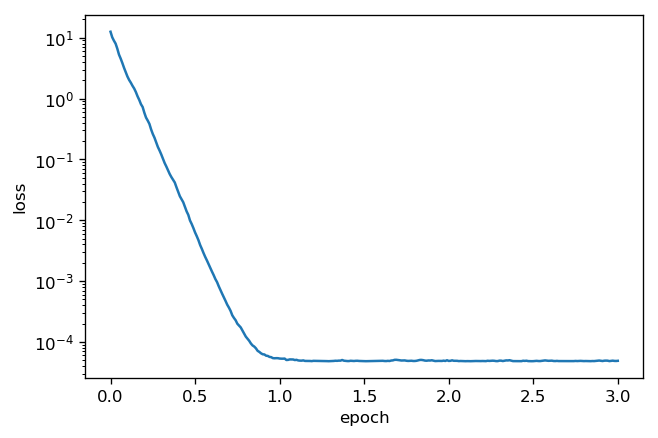

In [4]:
train(batch_size=10, rho=0.9999, epochs=3, period=10)

## 结论

* Adadelta没有学习率参数。


## 练习

* Adadelta为什么不需要设置学习率参数？它被什么代替了？

**吐槽和讨论欢迎点**[这里](https://discuss.gluon.ai/t/topic/2277)